In [1]:
import numpy as np
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import nibabel as nib

import os
from os.path import join as opj
from os.path import join, exists, split
import time
import urllib.request
import warnings
from pprint import pprint
import zipfile
import glob
warnings.filterwarnings('ignore')
from transformers import AutoFeatureExtractor, ClapModel
import torch
import torchaudio

from sklearn.linear_model import LogisticRegression, RidgeCV, Ridge
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder


import pandas as pd
from nilearn import maskers
from nilearn import plotting
import tqdm

from nilearn.glm.first_level import FirstLevelModel
from nilearn.image import concat_imgs, mean_img
import matplotlib.pyplot as plt
import nilearn
from nilearn.plotting import plot_design_matrix
from nilearn.plotting import plot_contrast_matrix
from importlib import reload # python 2.7 does not require this
from data_agg import *
import pickle
# from nltools.data import Brain_Data, Adjacency
# from nltools.stats import align

import seaborn as sns
import IPython.display as ipd
from sklearn.metrics import confusion_matrix

from diffusers import MusicLDMPipeline, AudioPipelineOutput, StableAudioPipeline
# from diffusers import DiffusionPipeline, AudioPipelineOutput
from IPython.display import Audio


os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
from data.audioLDM_pre import *
from transformers import AutoFeatureExtractor, ClapModel, ClapProcessor
import pandas as pd

repo_id = "ucsd-reach/musicldm"
musicldm_pipe = MusicLDMPipeline.from_pretrained(repo_id, torch_dtype=torch.float32)
device = "cuda:2" if torch.cuda.is_available() else "cpu"
musicldm_pipe = musicldm_pipe.to(device)

clap_model_id="laion/larger_clap_music_and_speech"
model = ClapModel.from_pretrained(clap_model_id).to(device)
processor = ClapProcessor.from_pretrained(clap_model_id)
feature_extractor = AutoFeatureExtractor.from_pretrained(clap_model_id)


orig_freq = 44100
sampling_rate_ldm = 16000
n_mel_channels = 64
mel_fmin = 0
mel_fmax = 8000
filter_length = 1024
hop_length = 160
win_length = 1024 
window = 'hann'
target_length = int(duration * sampling_rate_ldm / hop_length)
pad_wav_start_sample = 0
duration = 30.0


stft = STFT(
    filter_length=filter_length, 
    hop_length=hop_length, 
    win_length=win_length,
    window=window
)

def get_mel_features(audio):
    magnitude, phase = stft.transform(audio)
    mel_basis = librosa_mel_fn(
                sr=sampling_rate_ldm, n_fft=filter_length, n_mels=n_mel_channels, fmin=mel_fmin, fmax=mel_fmax
            )
    mel_basis = torch.from_numpy(mel_basis).float()
    magnitudes = magnitude.data
    mel_output = torch.matmul(mel_basis, magnitudes)
    mel_output = spectral_normalize(mel_output, torch.log).permute(0,2,1)

    return mel_output




Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 10.01it/s]


In [2]:
with open('/data01/data/fMRI_music_genre/data_dict/working_data_dict_vae' + '.pkl', 'rb') as file_to_read:
    working_data_dict = pickle.load(file_to_read)


def load_transformed_data(data_folder):
    # Initialize an empty dictionary to store the data
    loaded_data_dict = {}

    # Loop through all files in the data folder
    for filename in os.listdir(data_folder):
        # Construct the full path of the file
        file_path = os.path.join(data_folder, filename)
        
        # Extract the subject ID and key from the filename
        # Assuming filenames are in the format 'sub_key.ext'
        sub, key = filename.split('_', 1)
        key = key.rsplit('.', 1)[0]  # Removes extension part to get the key
        
        #repeat
        key = key.rsplit('.', 1)[0]  # Removes extension part to get the key

        # Initialize sub dictionary if it doesn't exist
        if sub not in loaded_data_dict:
            loaded_data_dict[sub] = {}

        # Determine the file type and load accordingly
        if filename.endswith('.npy'):
            loaded_data_dict[sub][key] = np.load(file_path)
        elif filename.endswith('.pkl'):
            with open(file_path, 'rb') as file:
                loaded_data_dict[sub][key] = pickle.load(file)

        print(f"Loaded {key} from {file_path}")

    return loaded_data_dict


# -----------------------------------------------------------------------------------------
transform_masking=True
subject_ids = ["sub-001", "sub-002", "sub-003", "sub-004", "sub-005"]

# mask_path = "mask_to_save/mask_top_512_voxels.nii.gz"
mask_path = "mask_to_save/mask_him_005.nii.gz"
# mask_path = "mask_01.nii.gz"
if transform_masking:
    base_masker=working_data_dict["sub-001"]["masker"]
    selected_indices=base_masker.transform(nib.load(mask_path))
    for sub in subject_ids:
        working_data_dict[sub]["train_fmri_avg"]=working_data_dict[sub]["train_fmri"].squeeze()[:,selected_indices.squeeze().astype(np.uint8)]
        working_data_dict[sub]["test_fmri_avg"]=working_data_dict[sub]["test_fmri"].squeeze()[:,selected_indices.squeeze().astype(np.uint8)]
       
if transform_masking:
    # Ensure the data directory exists
    data_folder = 'data'
    os.makedirs(data_folder, exist_ok=True)

    # Assuming working_data_dict is your main dictionary and 'sub' is defined
    for sub in subject_ids:
        for key, value in working_data_dict[sub].items():
            # Convert the value to a numpy array if it's not already one 
            print(key)

            # Define the path for the output file
            file_path = os.path.join(data_folder, f'{sub}_{key}.npy')

            # Check if the value is a numpy array
            if isinstance(value, np.ndarray):
                # Save the numpy array to a file with .npy extension
                np.save(file_path + '.npy', value)
                print(f"Saved {key} as an array to {file_path}.npy")
            else:
                # Save other types of data using pickle with .pkl extension
                with open(file_path + '.pkl', 'wb') as file:
                    pickle.dump(value, file, protocol=pickle.HIGHEST_PROTOCOL)
                print(f"Saved {key} using pickle to {file_path}.pkl")

            print(f"Saved {key} to {file_path}")      

else:
    # Use the function
    data_folder = 'data'  # Specify the data folder path
    working_data_dict = load_transformed_data(data_folder)


# -----------------------------------------------------------------------------------------
df_captions = pd.read_csv('/srv/nfs-data/sisko/matteoc/music' + '/brain2music-captions.csv')
print(df_captions.head())
captions_array = df_captions.to_numpy()
caption_dict = {item[0].split('_')[0]: item[1] for item in captions_array}

for subj in subject_ids:

    train_stim_name_list = working_data_dict[subj]['train_stim_name']
    train_stim_caption_list = []

    for file_path in train_stim_name_list:
        genre_number = file_path.split('/')[-1].replace('.wav', '')
        caption = caption_dict.get(genre_number, "Caption not found")
        train_stim_caption_list.append(caption)

    working_data_dict[subj]['train_stim_caption'] = train_stim_caption_list


for subj in subject_ids:

    test_stim_name_list = working_data_dict[subj]['test_stim_name']
    test_stim_caption_list = []

    for file_path in test_stim_name_list:
        genre_number = file_path.split('/')[-1].replace('.wav', '')
        caption = caption_dict.get(genre_number, "Caption not found")
        test_stim_caption_list.append(caption)

    working_data_dict[subj]['test_stim_caption'] = test_stim_caption_list


# -----------------------------------------------------------------------------------------

def process_data(data_dict, key_suffix, features_key, genre_key, stim_name_key, fmri_key, stim_caption_key, feat_vae_key):
    # Create DataFrame for fMRI and stimulus names
    df = pd.DataFrame(data_dict[fmri_key], dtype=float)
    df['Stimulus'] = data_dict[stim_name_key]
    
    # Group by 'Caption' and calculate the mean for fMRI data
    fmri_avg = df.groupby('Stimulus').mean().reset_index()
    
    # Create DataFrame for audio features and stimulus names
    df_features = pd.DataFrame(data_dict[features_key], dtype=float)
    df_features['Stimulus'] = data_dict[stim_name_key]
    
    # Group by 'Caption' and calculate the mean for audio features
    features_avg = df_features.groupby('Stimulus').mean().reset_index()
    
    # Handle genres (assuming genre data is aligned with stimuli names)
    df_genre = pd.DataFrame(data_dict[genre_key], columns=['Genre'])
    df_genre['Stimulus'] = data_dict[stim_name_key]
    
    # Since genre should be consistent for the same caption, we can take the first occurrence
    genre_avg = df_genre.groupby('Stimulus').first().reset_index()

    # Handle genres (assuming genre data is aligned with stimuli names)
    df_caption = pd.DataFrame(data_dict[stim_caption_key], columns=['Caption'])
    df_caption['Stimulus'] = data_dict[stim_name_key]
    
    # Since genre should be consistent for the same caption, we can take the first occurrence
    caption_avg = df_caption.groupby('Stimulus').first().reset_index()

    df_vae = pd.DataFrame(data_dict[feat_vae_key].reshape(data_dict[feat_vae_key].shape[0],-1), dtype=float)
    df_vae['Stimulus'] = data_dict[stim_name_key]
    
    vae_avg = df_vae.groupby('Stimulus').mean().reset_index()
    
    return {
        key_suffix + '_audio_feat': features_avg.drop(columns='Stimulus').values,
        key_suffix + '_genre': genre_avg['Genre'].values,
        key_suffix + '_stim_name_avg': fmri_avg['Stimulus'].values,
        key_suffix + '_caption_avg': caption_avg['Caption'].values,
        key_suffix + '_fmri_avg': fmri_avg.drop(columns='Stimulus').values,
        key_suffix + '_vae_avg': vae_avg.drop(columns='Stimulus').values
    }


working_data_dict_avg = {}
for sub in subject_ids:
    working_data_dict_avg[sub] = {}

    # Process training data
    working_data_dict_avg[sub].update(
        process_data(
            working_data_dict[sub],
            'train',
            'train_audio_feat',
            'train_genre',
            'train_stim_name',
            'train_fmri_avg',
            'train_stim_caption',
            'train_audio_vae'
        )
    )

    # Process testing data
    working_data_dict_avg[sub].update(
        process_data(
            working_data_dict[sub],
            'test',
            'test_audio_feat',
            'test_genre',
            'test_stim_name',
            'test_fmri_avg',
            'test_stim_caption',
            'test_audio_vae'
        )
    )





train_fmri
Saved train_fmri using pickle to data/sub-001_train_fmri.npy.pkl
Saved train_fmri to data/sub-001_train_fmri.npy
train_audio_feat
Saved train_audio_feat using pickle to data/sub-001_train_audio_feat.npy.pkl
Saved train_audio_feat to data/sub-001_train_audio_feat.npy
train_genre
Saved train_genre using pickle to data/sub-001_train_genre.npy.pkl
Saved train_genre to data/sub-001_train_genre.npy
train_audio
Saved train_audio using pickle to data/sub-001_train_audio.npy.pkl
Saved train_audio to data/sub-001_train_audio.npy
test_fmri
Saved test_fmri using pickle to data/sub-001_test_fmri.npy.pkl
Saved test_fmri to data/sub-001_test_fmri.npy
test_audio_feat
Saved test_audio_feat using pickle to data/sub-001_test_audio_feat.npy.pkl
Saved test_audio_feat to data/sub-001_test_audio_feat.npy
test_genre
Saved test_genre using pickle to data/sub-001_test_genre.npy.pkl
Saved test_genre to data/sub-001_test_genre.npy
test_audio
Saved test_audio using pickle to data/sub-001_test_audio.npy.

In [3]:
# STRONGER FUNCTIONAL ALIGNMENT

target_sub="sub-001"

# X_train_aligned = [working_data_dict_avg[source_sub]["train_fmri_avg"]]
# X_test_aligned  = [working_data_dict_avg[source_sub]["test_fmri_avg"]]
X_train_aligned = []
X_test_aligned  = []


for source_sub in subject_ids:

    print(source_sub)
    source_train=working_data_dict_avg[source_sub]["train_fmri_avg"]
    target_train=working_data_dict_avg[target_sub]["train_fmri_avg"]

    source_test=working_data_dict_avg[source_sub]["test_fmri_avg"]
    target_test=working_data_dict_avg[target_sub]["test_fmri_avg"]

    
    aligner=RidgeCV(alphas=[1e2,1e3,1e4,5e4], fit_intercept=True)
    aligner.fit(source_train,target_train)

    aligned_source_test=aligner.predict(source_test)
    aligned_source_train=aligner.predict(source_train)

    aligned_source_train_adj = (aligned_source_train - aligned_source_train.mean(0)) / (1e-8 + aligned_source_train.std(0))
    aligned_source_train_adj = target_train.std(0) * aligned_source_train_adj + target_train.mean(0)

    # Align and adjust source_test dataset
    aligned_source_test_adj = (aligned_source_test - aligned_source_test.mean(0)) / (1e-8 + aligned_source_test.std(0))
    aligned_source_test_adj = target_train.std(0) * aligned_source_test_adj + target_train.mean(0)
    
    X_train_aligned.append(aligned_source_train_adj)
    X_test_aligned.append(aligned_source_test_adj)
    
#concatenate all

X_train_aligned = np.concatenate(X_train_aligned,0)
X_test_aligned = np.concatenate(X_test_aligned,0)

#concatenate all the other keys

train_audio_feat_aligned = np.concatenate([working_data_dict_avg[sub]["train_audio_feat"] for sub in subject_ids],0)
test_audio_feat_aligned = np.concatenate([working_data_dict_avg[sub]["test_audio_feat"] for sub in subject_ids],0)

train_genre_aligned = np.concatenate([working_data_dict_avg[sub]["train_genre"] for sub in subject_ids],0)
test_genre_aligned = np.concatenate([working_data_dict_avg[sub]["test_genre"] for sub in subject_ids],0)

train_stim_name_avg_aligned = np.concatenate([working_data_dict_avg[sub]["train_stim_name_avg"] for sub in subject_ids],0)
test_stim_name_avg_aligned = np.concatenate([working_data_dict_avg[sub]["test_stim_name_avg"] for sub in subject_ids],0)

train_caption_avg_aligned = np.concatenate([working_data_dict_avg[sub]["train_caption_avg"] for sub in subject_ids],0)
test_caption_avg_aligned = np.concatenate([working_data_dict_avg[sub]["test_caption_avg"] for sub in subject_ids],0)

train_vae_avg_aligned = np.concatenate([working_data_dict_avg[sub]["train_vae_avg"] for sub in subject_ids],0)
test_vae_avg_aligned = np.concatenate([working_data_dict_avg[sub]["test_vae_avg"] for sub in subject_ids],0)


sub-001
sub-002
sub-003
sub-004
sub-005


In [ ]:
# TODO: provare ot.gromov.entropic_gromov_wasserstein su dati originali (cervello - feature)
# TODO: provare Mahalanobis Distances (mlkr = metric_learn.MLKR()) su dati predetti (feature - feature)

## OT def

In [4]:
import torch
import ot
from sklearn.linear_model import Ridge
import torch.nn.functional as F
import torch.nn as nn

X_train=X_train_aligned.copy()
X_test=X_test_aligned.copy()

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

X_train_torch = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)
train_audio_feat_torch = torch.tensor(train_audio_feat_aligned, dtype=torch.float32).to(device)

# Modello Ridge per mappare brain activity → latent space
brain_to_latent = Ridge(alpha=20)
brain_to_latent.fit(X_train, train_audio_feat_aligned)
audio_feat_pred_train = brain_to_latent.predict(X_train)
audio_feat_pred_train_torch = torch.tensor(audio_feat_pred_train, dtype=torch.float32).to(device)
audio_feat_pred_test = brain_to_latent.predict(X_test)
audio_feat_pred_test_torch = torch.tensor(audio_feat_pred_test, dtype=torch.float32).to(device)


# Matrice di similarità con cosine similarity
def cosine_similarity_matrix(A, B):
    A_norm = F.normalize(A, dim=1)
    B_norm = F.normalize(B, dim=1)
    return torch.mm(A_norm, B_norm.T)


# NT-Xent Loss (Contrastive)
def contrastive_loss(S, tau):
    S_exp = torch.exp(S / tau)
    loss = -torch.log(torch.diag(S_exp) / S_exp.sum(dim=1))
    return loss.mean()







In [5]:
import torch.optim as optim
import geomloss  # Library per differentiable OT in PyTorch
import torch.nn as nn
import torch
import numpy as np
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  

set_seed(55) # 55, 42, 432, 5, 17

# blur = 0.10, tau = 0.05 --> new optimal
blur = 0.50   # 0.50 for direct mapping 
sinkhorn = geomloss.SamplesLoss(loss="sinkhorn", p=2, blur=blur)
tau = 0.20     # 0.07 opt for first method, 0.20 opt for direct mapping 

class ContrastiveOT(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=768):
        super().__init__()
        self.output = nn.Linear(input_dim, output_dim, bias=True)
        self.dropout = nn.Dropout(p=0.5)  

    def forward(self, x):       
        x = self.dropout(x)    
        return self.output(x)  

# brain_to_latent_torch = ContrastiveOT(input_dim=X_train_torch.shape[1], output_dim=train_audio_feat_aligned.shape[1]).to(device)
brain_to_latent_torch = ContrastiveOT(input_dim=audio_feat_pred_train_torch.shape[1], output_dim=train_audio_feat_aligned.shape[1]).to(device)
optimizer = optim.Adam(brain_to_latent_torch.parameters(), lr=1e-3)


# Iterazioni per Joint OT & Contrastive Learning
n_epochs = 150
for epoch in range(n_epochs):
    
    optimizer.zero_grad()
    # audio_feat_pred_train_torch = brain_to_latent_torch(X_train_torch)
    audio_feat_pred_train_torch_b = brain_to_latent_torch(audio_feat_pred_train_torch)

    ot_loss = sinkhorn(audio_feat_pred_train_torch_b, train_audio_feat_torch)
    S = cosine_similarity_matrix(audio_feat_pred_train_torch_b, train_audio_feat_torch)
    contrastive_loss_value = contrastive_loss(S, tau)

    loss = ot_loss + contrastive_loss_value

    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{n_epochs}, Total Loss: {loss.item()}, OT Loss: {ot_loss.item()}, Contrastive Loss: {contrastive_loss_value.item()}")


with torch.no_grad():
    cost_matrix = torch.cdist(audio_feat_pred_train_torch_b, train_audio_feat_torch, p=2) ** 2  

with torch.no_grad():
    transport_plan = torch.exp(-cost_matrix / blur)  # 0.5 è il parametro blur

transport_plan /= transport_plan.sum(dim=1, keepdim=True)



Epoch 1/150, Total Loss: 8.201974868774414, OT Loss: 0.42931222915649414, Contrastive Loss: 7.772663116455078
Epoch 2/150, Total Loss: 7.808504104614258, OT Loss: 0.31597280502319336, Contrastive Loss: 7.4925312995910645
Epoch 3/150, Total Loss: 7.445065975189209, OT Loss: 0.2235003411769867, Contrastive Loss: 7.2215657234191895
Epoch 4/150, Total Loss: 7.132941722869873, OT Loss: 0.1542247235774994, Contrastive Loss: 6.978716850280762
Epoch 5/150, Total Loss: 6.878108978271484, OT Loss: 0.10743611305952072, Contrastive Loss: 6.770672798156738
Epoch 6/150, Total Loss: 6.672778129577637, OT Loss: 0.07930151373147964, Contrastive Loss: 6.59347677230835
Epoch 7/150, Total Loss: 6.521623611450195, OT Loss: 0.06762222945690155, Contrastive Loss: 6.454001426696777
Epoch 8/150, Total Loss: 6.405603885650635, OT Loss: 0.06791713833808899, Contrastive Loss: 6.337686538696289
Epoch 9/150, Total Loss: 6.315149307250977, OT Loss: 0.07508094608783722, Contrastive Loss: 6.240068435668945
Epoch 10/15

In [6]:
from sklearn.linear_model import LogisticRegression, RidgeCV, Ridge

brain_to_latent_torch.eval()
with torch.no_grad(): 
    # audio_feat_pred_ot = brain_to_latent_torch(X_test_torch)
    audio_feat_pred_ot = brain_to_latent_torch(audio_feat_pred_test_torch)


brain_to_latent=Ridge(alpha=20)
brain_to_latent.fit(X_train, train_audio_feat_aligned)
audio_feat_pred=brain_to_latent.predict(X_test)

In [72]:
ridge_cov = torch.cov(audio_feat_pred_train_torch.T)  # Covarianza dopo Ridge
ot_cov = torch.cov(brain_to_latent_torch(audio_feat_pred_train_torch).T)  # Covarianza dopo OT
ridge_eigvals = torch.linalg.eigvalsh(ridge_cov)

lambda_ridge = 20

ridge_shrink_eigvals = ridge_eigvals / (ridge_eigvals + lambda_ridge)
ot_eigvals = torch.linalg.eigvalsh(ot_cov)
w_eigvals = ot_eigvals / ridge_shrink_eigvals  # λ_j^W

# Analizza il guadagno
print(f"Guadagno di varianza medio: {w_eigvals.mean().item():.4f}")
print(f"Percentuale di componenti con λ_j^W > 1: {100 * (w_eigvals > 1).float().mean().item():.2f}%")
print(f"Percentuale di componenti con λ_j^W < 1: {100 * (w_eigvals < 1).float().mean().item():.2f}%")




Guadagno di varianza medio: 3.7647
Percentuale di componenti con λ_j^W > 1: 52.93%
Percentuale di componenti con λ_j^W < 1: 47.07%


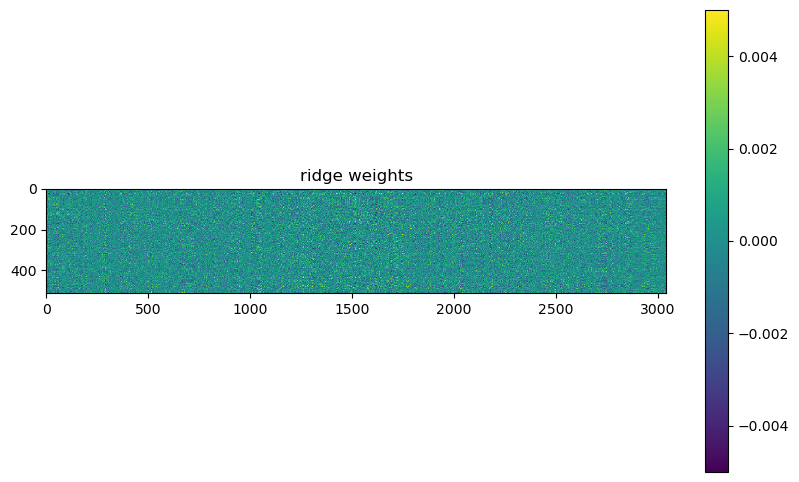

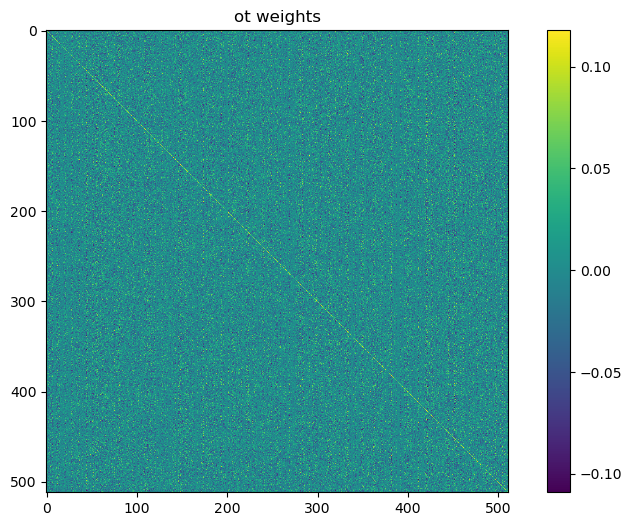

In [ ]:
ridge_weights = brain_to_latent.coef_
ot_weights = brain_to_latent_torch.output.weight.detach().cpu().numpy()

plt.figure(figsize=(10, 6))
plt.imshow(ridge_weights, interpolation="nearest", vmax=0.005, vmin=-0.005)
plt.title("ridge weights")
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(ot_weights, interpolation="nearest")
plt.title("ot weights")
plt.colorbar()
plt.show()

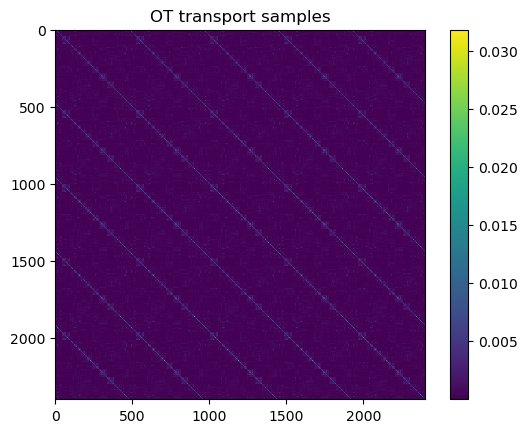

Optimal Transport Plan (Feature Space) Shape: torch.Size([512, 512])


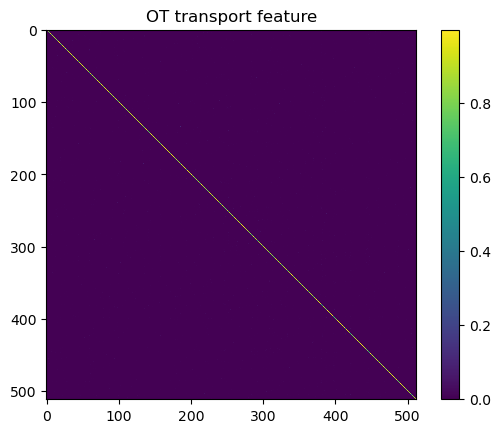

In [11]:
plt.figure(0)
plt.imshow(transport_plan.cpu(), interpolation="nearest")
plt.title("OT transport samples")
plt.colorbar()
plt.show()


# Trasponiamo le feature per applicare Sinkhorn sulle dimensioni delle feature
# X_feature_T = audio_feat_pred_train_torch_b.T  
X_feature_T = audio_feat_pred_train_torch.T
Y_feature_T = train_audio_feat_torch.T  

cost_matrix_feat = torch.cdist(X_feature_T, Y_feature_T, p=2) ** 2  

transport_plan_feat = torch.exp(-cost_matrix_feat / blur)  
transport_plan_feat /= transport_plan_feat.sum(dim=1, keepdim=True)

print("Optimal Transport Plan (Feature Space) Shape:", transport_plan_feat.shape)
plt.figure(0)
plt.imshow(transport_plan_feat.cpu().detach().numpy(), interpolation="nearest")
plt.title("OT transport feature")
plt.colorbar()
plt.show()


In [113]:
audio_feat_pred_ot.mean(), audio_feat_pred_ot.std()

(tensor(-0.0003, device='cuda:3'), tensor(0.0608, device='cuda:3'))

## OT study

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, normalize
from scipy.special import softmax
from sklearn.linear_model import LogisticRegression, RidgeCV, Ridge


X_train=X_train_aligned.copy()
X_test=X_test_aligned.copy()

# brain_to_latent=RidgeCV(alphas=[1e-2,0.1,1,2,5,8,10,15,20,50,1e2,1e3])
brain_to_latent=Ridge(alpha=20)
brain_to_latent.fit(X_train, train_audio_feat_aligned)
audio_feat_pred_train=brain_to_latent.predict(X_train)

# Features error
errors_per_feature = np.mean((train_audio_feat_aligned - audio_feat_pred_train)**2, axis=0)
# print(f"Feature errors: {errors_per_feature}")
threshold = np.percentile(errors_per_feature, 90)  # Top 10% delle feature peggiori
critical_features = np.where(errors_per_feature > threshold)[0]
print(f"Critical features: {critical_features}")


# a = X_train - np.min(X_train)
# b = train_audio_feat_aligned - np.min(train_audio_feat_aligned)
# a = softmax(a, 1)
# b = softmax(b, 1)

# transport_plan = get_transport(X_train, train_audio_feat_aligned, a, b)
# audio_feat_pred_ot=np.dot(X_test, transport_plan)
# # mean_pred, std_pred = np.mean(audio_feat_pred_ot, axis=0), np.std(audio_feat_pred_ot, axis=0)
# # audio_feat_pred_ot = (audio_feat_pred_ot * std_pred) + mean_pred

# audio_feat_pred=brain_to_latent.predict(X_test)


Critical features: [  0   6  26  32  43  82  84 101 104 124 130 139 145 160 161 163 173 190
 197 201 215 226 250 253 257 261 270 274 287 290 293 295 317 319 339 369
 371 374 395 403 404 413 418 433 436 440 449 470 479 480 490 496]


In [ ]:
import metric_learn
import ot

ot_emd = ot.da.SinkhornTransport(reg_e=5e-2, max_iter=50, metric='sqeuclidean', verbose=True)
# ot_emd = ot.da.MappingTransport(kernel="gaussian", mu=1e-2, eta=1e-3, bias=True, max_iter=10, verbose=True)
# ot_emd = ot.da.EMDTransport(metric="sqeuclidean")
ot_emd.fit(Xs=audio_feat_pred_train, Xt=train_audio_feat_aligned)

print(ot_emd.coupling_.shape)
audio_feat_pred=brain_to_latent.predict(X_test)
audio_feat_pred_ot=ot_emd.transform(Xs=audio_feat_pred)

# mlkr = metric_learn.MLKR()
# get_M = mlkr.fit_transform(audio_feat_pred, test_audio_feat_aligned)

errors_pre_all = test_audio_feat_aligned - audio_feat_pred
errors_post_all = test_audio_feat_aligned - audio_feat_pred_ot

plt.figure(figsize=(10, 5))
plt.hist(np.linalg.norm(errors_pre_all, axis=1), alpha=0.6, label='errors_pre', bins=30, color='r')
plt.hist(np.linalg.norm(errors_post_all, axis=1), alpha=0.6, label='errors_post', bins=30, color='k')
# plt.hist(np.linalg.norm(critical_aligned_test, axis=1), alpha=0.5, label='critical_aligned', bins=30, color='y')
plt.legend()
plt.title("Error Distribution Before and After OT")
plt.show()

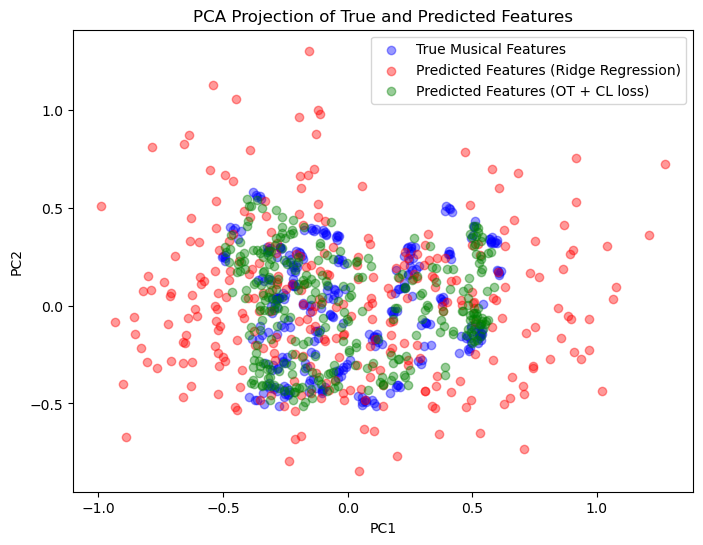

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X_real = test_audio_feat_aligned  # Feature reali
X_pred = audio_feat_pred  # Feature stimate prima di OT
X_pred_ot = audio_feat_pred_ot  # Feature stimate dopo OT

pca = PCA(n_components=2)
X_all = np.vstack([X_real, X_pred, X_pred_ot]) 
X_pca = pca.fit_transform(X_all)  

X_real_pca = X_pca[:len(X_real)]
X_pred_pca = X_pca[len(X_real):len(X_real) + len(X_pred)]
X_pred_ot_pca = X_pca[len(X_real) + len(X_pred):]

plt.figure(figsize=(8, 6))
plt.scatter(X_real_pca[:, 0], X_real_pca[:, 1], alpha=0.4, label="True Musical Features", color='b')
plt.scatter(X_pred_pca[:, 0], X_pred_pca[:, 1], alpha=0.4, label="Predicted Features (Ridge Regression)", color='r')
plt.scatter(X_pred_ot_pca[:, 0], X_pred_ot_pca[:, 1], alpha=0.4, label="Predicted Features (OT + CL loss)", color='g')
plt.legend()
plt.title("PCA Projection of True and Predicted Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


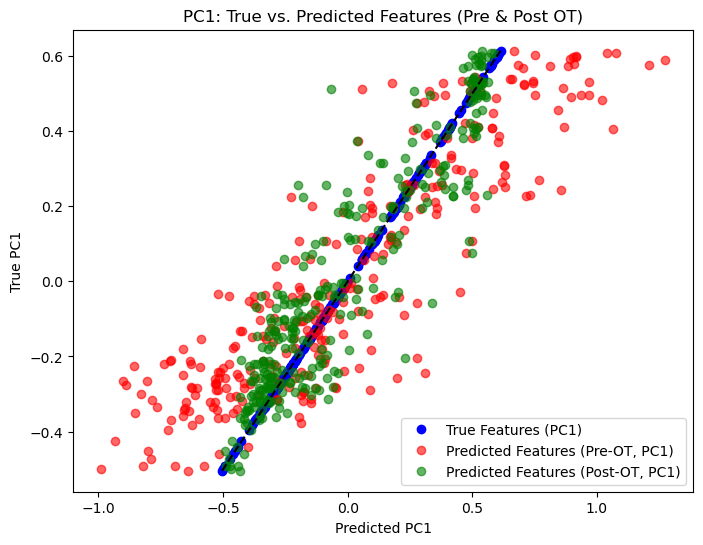

In [41]:
principal_comp = 0

plt.figure(figsize=(8, 6))
plt.plot(X_real_pca[:, principal_comp], X_real_pca[:, principal_comp], 'bo', label="True Features (PC1)")  # Identità diagonale
plt.plot(X_pred_pca[:, principal_comp], X_real_pca[:, principal_comp], 'ro', alpha=0.6, label="Predicted Features (Pre-OT, PC1)")
plt.plot(X_pred_ot_pca[:, principal_comp], X_real_pca[:, principal_comp], 'go', alpha=0.6, label="Predicted Features (Post-OT, PC1)")

plt.plot([min(X_real_pca[:, principal_comp]), max(X_real_pca[:, principal_comp])], 
         [min(X_real_pca[:, principal_comp]), max(X_real_pca[:, principal_comp])], 'k--')  # Linea identità

plt.legend()
plt.title("PC1: True vs. Predicted Features (Pre & Post OT)")
plt.xlabel("Predicted PC1")
plt.ylabel("True PC1")
plt.show()


In [25]:
errors_pre_all.mean(), errors_pre_all.std(), errors_post_all.mean(), errors_post_all.std()

(0.00016374334386824163,
 0.03750765467056626,
 0.00023787970005912883,
 0.028263301968684484)

It.  |Err         
-------------------
    0|6.002614e-04|
   10|9.661705e-11|


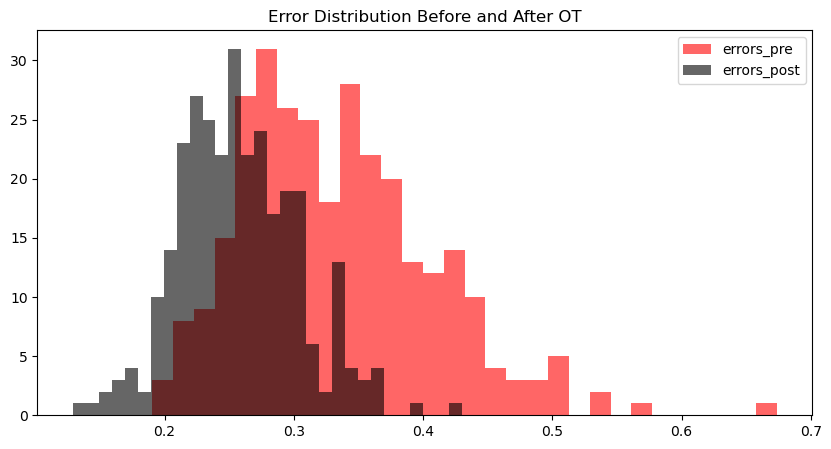

In [21]:
critical_target = train_audio_feat_aligned[:, critical_features]
brain_to_latent_critical = Ridge(alpha=20.0)  # Parametro ottimizzato
brain_to_latent_critical.fit(X_train, critical_target)
critical_preds = brain_to_latent_critical.predict(X_train)

ot_emd_critical = ot.da.SinkhornTransport(reg_e=1e-1, max_iter=50, verbose=True)
# ot_emd_critical = ot.da.EMDTransport(metric="sqeuclidean")
ot_emd_critical.fit(Xs=critical_preds, Xt=critical_target)
critical_aligned = ot_emd_critical.transform(Xs=critical_preds)
critical_preds_test = brain_to_latent_critical.predict(X_test)
critical_aligned_test = ot_emd_critical.transform(Xs=critical_preds_test)

errors_pre = test_audio_feat_aligned[:, critical_features] - critical_preds_test
errors_post = test_audio_feat_aligned[:, critical_features] - critical_aligned_test

plt.figure(figsize=(10, 5))
plt.hist(np.linalg.norm(errors_pre, axis=1), alpha=0.6, label='errors_pre', bins=30, color='r')
plt.hist(np.linalg.norm(errors_post, axis=1), alpha=0.6, label='errors_post', bins=30, color='k')
# plt.hist(np.linalg.norm(critical_aligned_test, axis=1), alpha=0.5, label='critical_aligned', bins=30, color='y')
plt.legend()
plt.title("Error Distribution Before and After OT")
plt.show()


In [922]:
errors_pre.mean(), errors_pre.std(), errors_post.mean(), errors_post.std()

(0.0009318490643535986,
 0.047327025823536505,
 0.0009586400048551888,
 0.03625384090623801)

In [923]:
audio_feat_pred_ot=brain_to_latent.predict(X_test)
audio_feat_pred_ot[:, critical_features]=critical_aligned_test

In [534]:
print(ot_emd.coupling_.shape)
audio_feat_pred=brain_to_latent.predict(X_test)
print(audio_feat_pred.shape)
# audio_feat_pred_ot=ot_emd.inverse_transform(Xs=audio_feat_pred, Xt=test_audio_feat_aligned)
audio_feat_pred_ot=ot_emd.transform(Xs=audio_feat_pred)
# audio_feat_pred_ot=audio_feat_pred @ T

(2400, 2400)
(300, 512)


In [58]:
ot_emd.coupling_.max(), ot_emd.coupling_.min(), ot_emd.coupling_.shape

(0.00020463853415553294, 1.6075317165986402e-27, (2400, 2400))

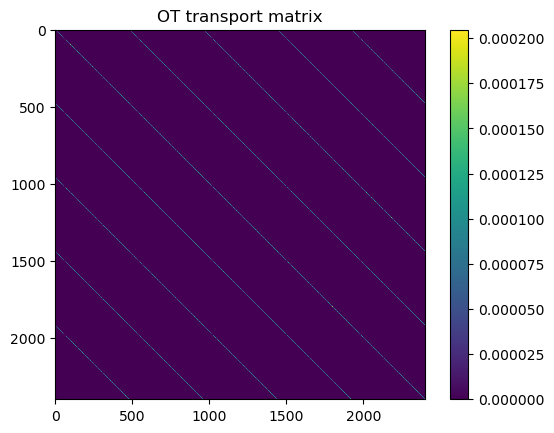

In [9]:
plt.figure(0)
plt.imshow(ot_emd.coupling_, interpolation="nearest")
plt.title("OT transport matrix")
plt.colorbar()
plt.show()

In [373]:
# audio_feat_pred_ot = np.nan_to_num(audio_feat_pred_ot, nan=0)

In [10]:
print(audio_feat_pred.shape)
print(test_audio_feat_aligned.shape)
print(audio_feat_pred_ot.shape)
print(np.mean(audio_feat_pred))
print(np.mean(test_audio_feat_aligned))
print(np.mean(audio_feat_pred_ot))
print(np.std(audio_feat_pred))
print(np.std(test_audio_feat_aligned))
print(np.std(audio_feat_pred_ot))

(300, 512)
(300, 512)
(300, 512)
-0.0005942661985135745
-0.00043052285464533304
-0.0006702486755653823
0.04902074463935425
0.04325746154721229
0.03903428124524318


(array([ 7.,  5.,  8., 38., 72., 57., 48., 35., 21.,  9.]),
 array([-0.07982863, -0.06657675, -0.05332488, -0.040073  , -0.02682113,
        -0.01356925, -0.00031738,  0.0129345 ,  0.02618637,  0.03943825,
         0.05269012]),
 <BarContainer object of 10 artists>)

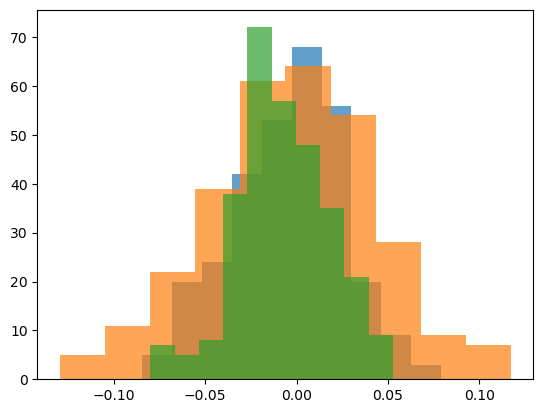

In [126]:
select_feature = 7

plt.hist(audio_feat_pred[:,select_feature], alpha=0.7)     # blue
plt.hist(audio_feat_pred_ot[:,select_feature].cpu().numpy(), alpha=0.7) # orange
plt.hist(test_audio_feat_aligned[:,select_feature], alpha=0.7) # green

In [127]:
pc_before = []
pc_after = []
audio_feat_pred_ot = audio_feat_pred_ot.cpu()

for obs_idx in range(audio_feat_pred_ot.shape[0]):
    pc_b = np.corrcoef(audio_feat_pred[obs_idx], test_audio_feat_aligned[obs_idx])[0,1]
    pc_before.append(pc_b)

    pc_a = np.corrcoef(audio_feat_pred_ot[obs_idx], test_audio_feat_aligned[obs_idx])[0,1]
    pc_after.append(pc_a)

print("Mean PC before OT:", np.array(pc_before).mean())
print("Mean PC after OT:", np.array(pc_after).mean())

Mean PC before OT: 0.6815382980125015
Mean PC after OT: 0.5234099177760524


In [128]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=5, metric='cosine').fit(test_audio_feat_aligned[0:60])
distances_before, indices_before = nbrs.kneighbors(audio_feat_pred)
distances, top_indices = nbrs.kneighbors(audio_feat_pred_ot)

print("Mean distance before OT:", distances_before.mean())
print("Mean distance after OT:", distances.mean())

Mean distance before OT: 0.2939392917671454
Mean distance after OT: 0.4628663474934779


In [129]:
top_indices[43]

array([42, 43, 47, 45, 22])

In [130]:
top_indices_3 = top_indices[:,:3]
top_indices_3subj = top_indices_3.reshape([5, 60, 3])
print(top_indices_3.shape)
print(top_indices_3subj.shape)

(300, 3)
(5, 60, 3)


In [131]:
sub_idx = 4
count_top_1 = 0
count_top_3 = 0
for idx in range(60):
    file_name_with_extension = str(test_stim_name_avg_aligned[:60][idx]).split('/')[-1]
    file_name = file_name_with_extension.replace('.wav', '')
    file_names_retrieved = [file_path.split('/')[-1].replace('.wav', '') for file_path in test_stim_name_avg_aligned[:60][top_indices_3subj[sub_idx][idx]]]
    if file_name == file_names_retrieved[0]:
        count_top_1 = count_top_1 + 1
    if file_name in file_names_retrieved:
        count_top_3 = count_top_3 + 1
    # print(test_genre_aligned[:60][idx])
    # print(test_stim_name_avg_aligned[:60][idx])
    # print(test_genre_aligned[:60][top_indices_3[idx]])
    # print(test_stim_name_avg_aligned[:60][top_indices_3[idx]])
    # ipd.Audio(working_data_dict_avg[f"sub-00{sub_idx}"]["test_stim_name_avg"][idx],rate=22500)

print('count_top_1: ',count_top_1)
print('count_top_3: ',count_top_3)

count_top_1:  20
count_top_3:  35


In [642]:
sub_idx = 4
count_top_1 = 0
count_top_3 = 0
for idx in range(60):
    genre_orig = test_genre_aligned[:60][idx]
    genre_decod_list = [genre_decod for genre_decod in test_genre_aligned[:60][top_indices_3subj[sub_idx][idx]]]    
    if genre_orig == genre_decod_list[0]:
        count_top_1 = count_top_1 + 1
    if genre_orig in genre_decod_list:
        count_top_3 = count_top_3 + 1

print('count_top_1: ',count_top_1)
print('count_top_3: ',count_top_3)

count_top_1:  38
count_top_3:  50


disco.00072
Moviepy - Building video /home/matteoc/genre-to-fmri/spectr_retrieve/pop_ot/disco.00072_dec_3.mp4.
MoviePy - Writing audio in disco.00072_dec_3TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /home/matteoc/genre-to-fmri/spectr_retrieve/pop_ot/disco.00072_dec_3.mp4



Moviepy - Done !
Moviepy - video ready /home/matteoc/genre-to-fmri/spectr_retrieve/pop_ot/disco.00072_dec_3.mp4


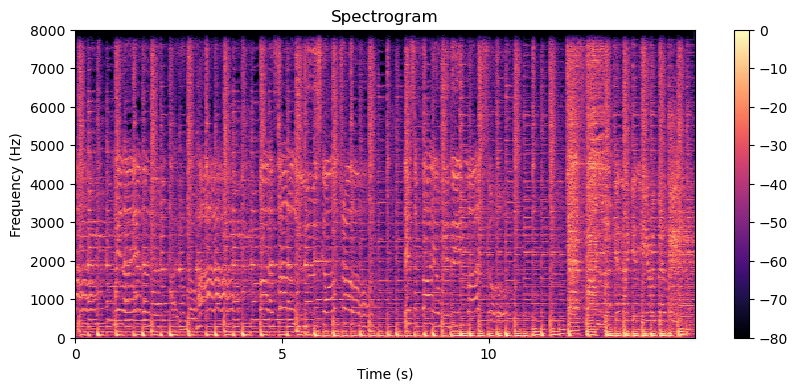

In [86]:
import librosa
from moviepy.editor import ImageClip, AudioFileClip

flag = '_dec_3'
start_track = 22
path_to_save = "/home/matteoc/genre-to-fmri/spectr_retrieve/pop_ot/"
file_path = test_stim_name_avg_aligned[:60][start_track:start_track+1][0]
file_name = os.path.splitext(os.path.basename(file_path))[0]
print(file_name)

audio_retrieve = librosa.load(file_path, sr=16000)
X_retrieve = librosa.stft(audio_retrieve[0][0:240000])    # 15 seconds
Xdb_retrieve = librosa.amplitude_to_db(abs(X_retrieve), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(Xdb_retrieve, sr=16000, x_axis='time', y_axis='hz',)
plt.colorbar()
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.savefig(os.path.join(path_to_save, f'{file_name}.png'))

# Load the image and audio
image_clip = ImageClip(path_to_save+file_name+'.png').set_duration(15)  # Duration should match the audio length
audio_clip = AudioFileClip(file_path).set_duration(15)

path_to_save_mp4 = "/home/matteoc/genre-to-fmri/spectr_retrieve/pop_ot/"
# Combine them into a video
video = image_clip.set_audio(audio_clip)
video.write_videofile(path_to_save_mp4+file_name+flag+'.mp4', fps=24)



In [54]:
audio_retrieve[0].shape

(480214,)

In [713]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

neuroposter_cmap = LinearSegmentedColormap.from_list('Neuroposter', (
    # Edit this gradient at https://eltos.github.io/gradient/#Neuroposter=3C0080-9A5598-CFD357
    (0.000, (0.235, 0.000, 0.502)),
    (0.500, (0.604, 0.333, 0.596)),
    (1.000, (0.812, 0.827, 0.341))))

labels = ['Blues', 'Classical', 'Country', 'Disco', 'Hip-Hop', 'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock']

def compute_cosine_matrix(real_embeddings, predicted_embeddings):

    real_embeddings = torch.nn.functional.normalize(real_embeddings, dim=1)
    predicted_embeddings = torch.nn.functional.normalize(predicted_embeddings, dim=1)
    similarity_matrix = torch.mm(real_embeddings, predicted_embeddings.T)  # Matrice (num_real x num_pred)
    
    return similarity_matrix.numpy()


def plot_similarity_matrix(similarity_matrix, labels, threshold=0.85):
    
    # masked_matrix = np.where(similarity_matrix < threshold, np.nan, similarity_matrix)
    plt.figure(figsize=(6,4.5))
    ax = sns.heatmap(similarity_matrix, vmin=-0.3, vmax=1, annot=False, cmap=neuroposter_cmap) 
    
    ax.set_xticks(np.arange(2.5, similarity_matrix.shape[1], 6))
    ax.set_yticks(np.arange(2.5, similarity_matrix.shape[0], 6))

    ax.set_xticklabels(labels[:similarity_matrix.shape[1] // 6], fontsize=6)
    ax.set_yticklabels(labels[:similarity_matrix.shape[0] // 6], fontsize=6)

    ax.tick_params(axis='both', which='both', length=0)
    
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    
    # Customize the grid lines
    for i in range(0, similarity_matrix.shape[0]+1, 6):
        ax.axhline(i, color='black', linewidth=0.5)
        ax.axvline(i, color='black', linewidth=0.5)

    ax.axhline(y=0, color='black', linewidth=1.5)
    ax.axhline(y=similarity_matrix.shape[0], color='black', linewidth=1.5)
    ax.axvline(x=0, color='black', linewidth=1.5)
    ax.axvline(x=similarity_matrix.shape[1], color='black', linewidth=1.5)

    plt.xlabel('Predicted Embeddings')
    plt.ylabel('Real Embeddings')
    plt.title('Cosine Similarity Matrix')
    plt.show()


def reorder_similarity_matrix(similarity_matrix, labels):
    
    within_group_accuracies = []
    between_group_accuracies = []
    for i in range(0, similarity_matrix.shape[0], 6):
        group = similarity_matrix[i:i+6, i:i+6]
        within_group_accuracy = np.mean(group)
        within_group_accuracies.append(within_group_accuracy)

        between_group_similarity = np.concatenate((similarity_matrix[i:i+6, :i], similarity_matrix[i:i+6, i+6:]), axis=1)
        between_group_accuracy = np.mean(between_group_similarity)
        between_group_accuracies.append(between_group_accuracy)
    
    composite_metrics = np.array(within_group_accuracies) - np.array(between_group_accuracies)
    sorted_indices = np.argsort(composite_metrics)[::-1]
    new_indices = np.concatenate([np.arange(i * 6, (i + 1) * 6) for i in sorted_indices])
    reordered_matrix = similarity_matrix[new_indices][:, new_indices]
    reordered_labels = [labels[i] for i in sorted_indices]
    
    return reordered_matrix, reordered_labels



max sim_matrix:  0.8274262103675526
min sim_matrix:  -0.4774521972988306
mean sim_matrix:  0.17874631025103474


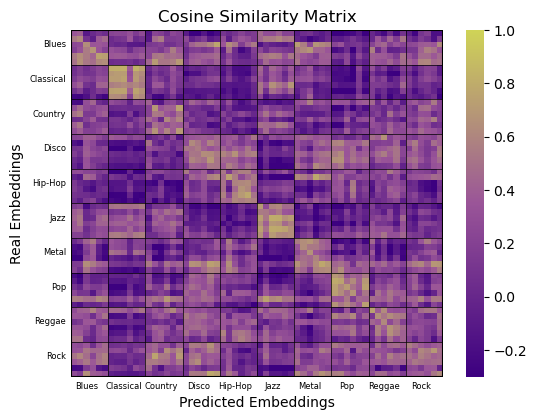

max sim_matrix:  0.9110106220239871
min sim_matrix:  -0.36226142342790607
mean sim_matrix:  0.40928862852482184


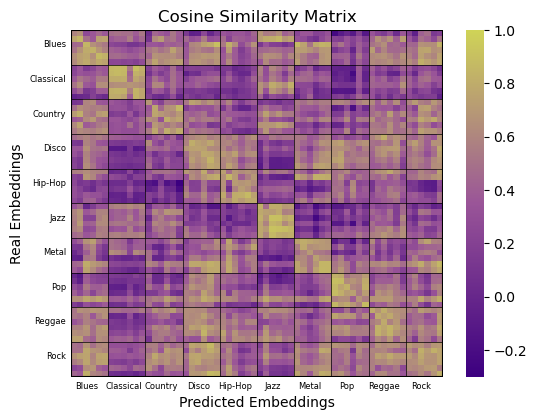

In [714]:
import torch


audio_feat_pred_tensor = torch.tensor(audio_feat_pred)
test_audio_feat_aligned_tensor = torch.tensor(test_audio_feat_aligned)
audio_feat_pred_view = audio_feat_pred_tensor.view(5, 60, audio_feat_pred_tensor.shape[-1])
test_audio_feat_aligned_view = test_audio_feat_aligned_tensor.view(5, 60, test_audio_feat_aligned_tensor.shape[-1])

audio_feat_pred_view = audio_feat_pred_view.mean(dim=0)
test_audio_feat_aligned_view = test_audio_feat_aligned_view.mean(dim=0)

audio_feat_pred_ot_tensor = torch.tensor(audio_feat_pred_ot)
audio_feat_pred_ot_view = audio_feat_pred_ot_tensor.view(5, 60, audio_feat_pred_ot_tensor.shape[-1])
audio_feat_pred_ot_view = audio_feat_pred_ot_view.mean(dim=0)

similarity_matrix_ot = compute_cosine_matrix(audio_feat_pred_ot_view.double().cpu(), test_audio_feat_aligned_view.cpu())
print('max sim_matrix: ', np.max(similarity_matrix_ot))
print('min sim_matrix: ', np.min(similarity_matrix_ot))
print('mean sim_matrix: ', np.mean(similarity_matrix_ot))
plot_similarity_matrix(similarity_matrix_ot, labels)

similarity_matrix = compute_cosine_matrix(audio_feat_pred_view.double().cpu(), test_audio_feat_aligned_view.cpu())
print('max sim_matrix: ', np.max(similarity_matrix))
print('min sim_matrix: ', np.min(similarity_matrix))
print('mean sim_matrix: ', np.mean(similarity_matrix))
plot_similarity_matrix(similarity_matrix, labels)



Statistiche KS test: 0.3723
P-value: 0.0000
Le distribuzioni degli elementi off-diagonal sono significativamente diverse.


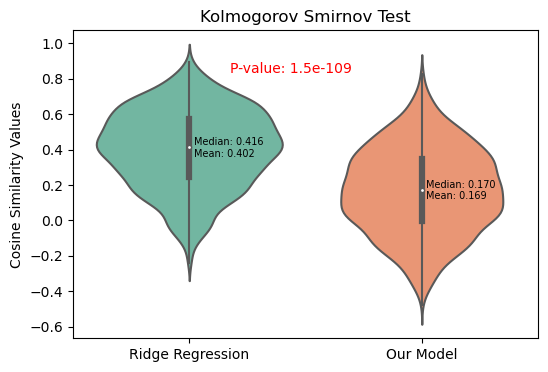

In [715]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import seaborn as sns


def extract_diagonal_off_diagonal(matrix):
    """ Estrae i valori diagonali e off-diagonali da una matrice quadrata """
    diagonal_values = np.diag(matrix)
    off_diagonal_values = matrix[np.triu_indices_from(matrix, k=1)]  # Solo sopra la diagonale per evitare duplicati
    return diagonal_values, off_diagonal_values

diag_1, off_diag_1 = extract_diagonal_off_diagonal(similarity_matrix)
diag_2, off_diag_2 = extract_diagonal_off_diagonal(similarity_matrix_ot)

ks_stat, p_value = ks_2samp(off_diag_1, off_diag_2)

print(f"Statistiche KS test: {ks_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Le distribuzioni degli elementi off-diagonal sono significativamente diverse.")
else:
    print("Non ci sono differenze significative tra le distribuzioni off-diagonal.")

data = [off_diag_1, off_diag_2]  # Distribuzioni off-diagonali
labels = ['Ridge Regression', 'Our Model']

plt.figure(figsize=(6, 4))
sns.violinplot(data=data, palette='Set2')
plt.xticks(ticks=[0, 1], labels=labels)
# plt.boxplot(data, labels=labels)

mediane = [np.median(off_diag_1), np.median(off_diag_2)]
means = [np.mean(off_diag_1), np.mean(off_diag_2)]
dvstd = [np.std(off_diag_1), np.std(off_diag_2)]

for i in range(2):
    plt.text(i + 0.02, mediane[i], f'Median: {mediane[i]:.3f}', ha='left', va='bottom', fontsize=7)
    plt.text(i + 0.02, means[i], f'Mean: {means[i]:.3f}', ha='left', va='top', fontsize=7)

plt.text(0.7, max(np.concatenate([off_diag_1, off_diag_2])), f'P-value: {p_value:.1e}', ha='right', va='top', color='red', fontsize=10)


# Impostazioni del grafico
plt.title('Kolmogorov Smirnov Test')
plt.ylabel('Cosine Similarity Values')
plt.show()


In [365]:
from scipy.stats import permutation_test

result = permutation_test((off_diag_1, off_diag_2), statistic=lambda x, y: np.mean(x) - np.mean(y), 
                          permutation_type='independent', alternative='two-sided', n_resamples=10000)

print(f"Statistiche Permutation Test: {result.statistic:.6f}")
print(f"P-value: {result.pvalue:.7f}")

if result.pvalue < 0.05:
    print("Le distribuzioni sono significativamente diverse.")
else:
    print("Non ci sono differenze significative.")


Statistiche Permutation Test: 0.193587
P-value: 0.0002000
Le distribuzioni sono significativamente diverse.


In [366]:
print(f"Media off-diagonal Ridge only: {np.mean(off_diag_1):.4f} ± {np.std(off_diag_1):.4f}")
print(f"Media off-diagonal Ridge + OT + CL: {np.mean(off_diag_2):.4f} ± {np.std(off_diag_2):.4f}")


Media off-diagonal Ridge only: 0.4023 ± 0.2214
Media off-diagonal Ridge + OT + CL: 0.2087 ± 0.2123


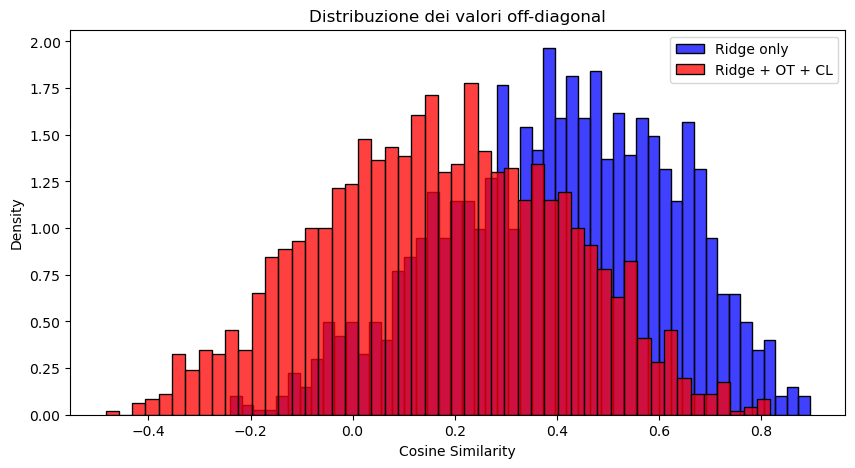

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribuzioni degli elementi off-diagonali
plt.figure(figsize=(10,5))
sns.histplot(off_diag_1, bins=50, color='blue', label='Ridge only', stat="density")
sns.histplot(off_diag_2, bins=50, color='red', label='Ridge + OT + CL', stat="density")
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.title("Distribuzione dei valori off-diagonal")
plt.legend()
plt.show()


## OT starting

In [131]:
import numpy as np
from scipy.spatial.distance import squareform, pdist, cdist
from scipy.optimize import linprog
import ot
import ot.plot


def demo_wasserstein(x, p, q):
    """
    Computes order-2 Wasserstein distance between two
    discrete distributions.

    Parameters
    ----------
    x : ndarray, has shape (num_bins, dimension)
    
        Locations of discrete atoms (or "spatial bins")

    p : ndarray, has shape (num_bins,)

        Probability mass of the first distribution on each atom.

    q : ndarray, has shape (num_bins,)

        Probability mass of the second distribution on each atom.

    Returns
    -------
    dist : float

        The Wasserstein distance between the two distributions.

    T : ndarray, has shape (num_bins, num_bins)

        Optimal transport plan. Satisfies p == T.sum(axis=0)
        and q == T.sum(axis=1).

    Note
    ----
    This function is meant for demo purposes only and is not
    optimized for speed. It should still work reasonably well
    for moderately sized problems.
    """

    # Check inputs.
    if (abs(p.sum() - 1) > 1e-9) or (abs(p.sum() - q.sum()) > 1e-9):
        raise ValueError("Expected normalized probability masses.")

    if np.any(p < 0) or np.any(q < 0):
        raise ValueError("Expected nonnegative mass vectors.")

    if (x.shape[0] != p.size) or (p.size != q.size):
        raise ValueError("Dimension mismatch.")

    # Compute pairwise costs between all xs.
    n, d = x.shape
    C = squareform(pdist(x, metric="sqeuclidean"))

    # Scipy's linear programming solver will accept the problem in
    # the following form:
    # 
    # minimize     c @ t        over t
    # subject to   A @ t == b
    #
    # where we specify the vectors c, b and the matrix A as parameters.

    # Construct matrices Ap and Aq encoding marginal constraints.
    # We want (Ap @ t == p) and (Aq @ t == q).
    Ap, Aq = [], []
    z = np.zeros((n, n))
    z[:, 0] = 1

    for i in range(n):
        Ap.append(z.ravel())
        Aq.append(z.transpose().ravel())
        z = np.roll(z, 1, axis=1)

    # We can leave off the final constraint, as it is redundant.
    # See Remark 3.1 in Peyre & Cuturi (2019).
    A = np.row_stack((Ap, Aq))[:-1]
    b = np.concatenate((p, q))[:-1]

    # Solve linear program, recover optimal vector t.
    result = linprog(C.ravel(), A_eq=A, b_eq=b)

    # Reshape optimal vector into (n x n) transport plan matrix T.
    T = result.x.reshape((n, n))

    # Return Wasserstein distance and transport plan.
    return np.sqrt(np.sum(T * C)), T




In [132]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
from sklearn.decomposition import PCA
from scipy.special import softmax

X_normalized = softmax(audio_feat_pred,1)
Y_normalized = softmax(test_audio_feat_aligned,1)

idx_song = 2
distances = []
transport_plans = []
for obs_idx in tqdm.trange(5):
    x = np.stack([audio_feat_pred[obs_idx], test_audio_feat_aligned[obs_idx]], axis=1)
    p = X_normalized[obs_idx]
    q = Y_normalized[obs_idx]
    
    # Calcolo OT
    dist, T = demo_wasserstein(x, p, q)
    # dist, T = T_from_OT_lib(p.reshape(1, -1), q.reshape(1, -1), 1e-3)
    distances.append(dist)
    transport_plans.append(T)


# Output
print("Optimal transport distances:", distances)

100%|██████████| 5/5 [00:44<00:00,  8.92s/it]

Optimal transport distances: [0.003988030136500491, 0.0025479509866943397, 0.002446366933306361, 0.0019731759945613094, 0.0021275820080435335]


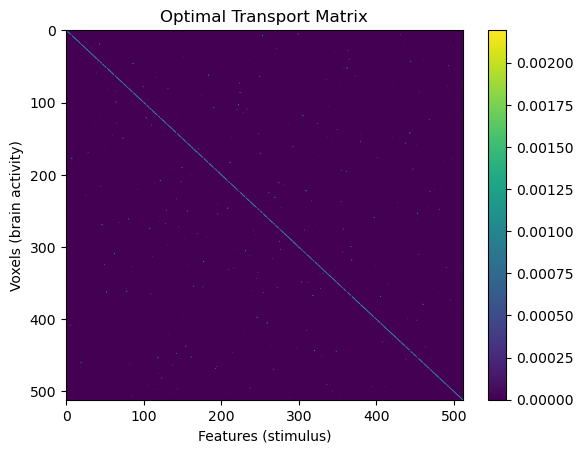

In [133]:
plt.imshow(transport_plans[idx_song], aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Optimal Transport Matrix")
plt.xlabel("Features (stimulus)")
plt.ylabel("Voxels (brain activity)")
plt.show()

### Regularized

In [134]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from scipy.special import softmax
import ot
import ot.plot

def f(G):
    return np.sum(G * np.log(G + 1e-10))  # Regolarizzazione entropica

def df(G):
    return np.log(G + 1e-10) + 1

idx_song = 2
reg = 1e-3
distances = []
transport_plans = []
for obs_idx in tqdm.trange(5):
    x = np.stack([audio_feat_pred[obs_idx], test_audio_feat_aligned[obs_idx]], axis=1)
    # M = squareform(pdist(x, metric="sqeuclidean"))
    M = pairwise_distances(x, metric="sqeuclidean")
    M /= (M.max())
    a = softmax(audio_feat_pred[obs_idx])
    b = softmax(test_audio_feat_aligned[obs_idx])
    Gl2 = ot.optim.cg(a, b, M, reg, f, df, verbose=False)
    # Gl2 = ot.sinkhorn(a, b, M, reg)
    transport_plans.append(Gl2)

transport_plan_mean = np.mean(transport_plans, axis=0)


100%|██████████| 5/5 [00:38<00:00,  7.79s/it]


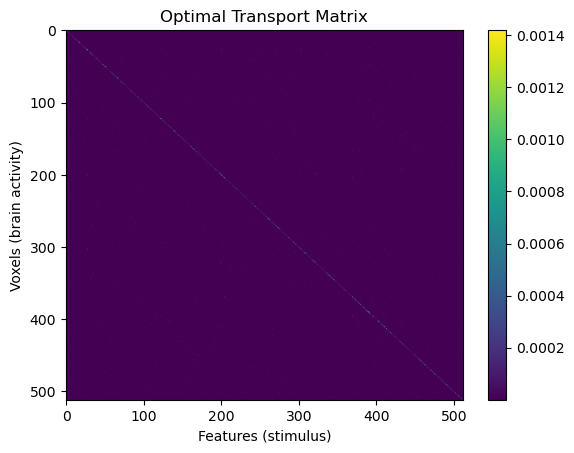

In [135]:
plt.imshow(transport_plan_mean, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Optimal Transport Matrix")
plt.xlabel("Features (stimulus)")
plt.ylabel("Voxels (brain activity)")
plt.show()

In [136]:
pc_before = []
pc_after = []
transformed_feat = []

for obs_idx in range(5):
    pc_b = np.corrcoef(audio_feat_pred[obs_idx], test_audio_feat_aligned[obs_idx])[0,1]
    pc_before.append(pc_b)

    transformed_feat_val = np.dot(transport_plans[obs_idx], audio_feat_pred[obs_idx])
    pc_a = np.corrcoef(transformed_feat_val, test_audio_feat_aligned[obs_idx])[0,1]
    pc_after.append(pc_a)
    transformed_feat.append(transformed_feat_val)

print("Mean PC before OT:", pc_before)
print("Mean PC after OT:", pc_after)

Mean PC before OT: [0.45890226716109767, 0.6748811837647491, 0.7810725950811732, 0.8026903205791344, 0.800750292392609]
Mean PC after OT: [0.470037902751549, 0.6962076055978064, 0.7947592171134777, 0.8301400744321394, 0.8241212721032155]


### Sinkhorn - global

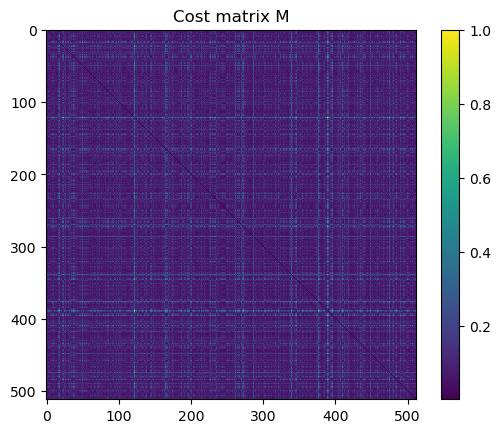

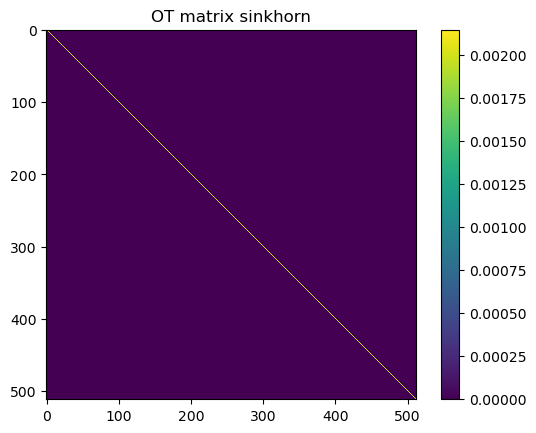

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from scipy.special import softmax
import ot
import ot.plot

def softmax_fun(data):
    exp_data = np.exp(data - np.max(data, axis=1, keepdims=True))  # Stabilità numerica
    return exp_data / exp_data.sum(axis=1, keepdims=True)

T = 1
X_normalized = softmax(audio_feat_pred_train/T, axis=1)
Y_normalized = softmax(train_audio_feat_aligned/T, axis=1)

# M = squareform(pdist(x, metric="sqeuclidean"))
M = pairwise_distances(audio_feat_pred_train.T, train_audio_feat_aligned.T, metric="sqeuclidean")
M /= (M.max())
G0 = ot.emd(X_normalized.mean(axis=0), Y_normalized.mean(axis=0), M)

plt.figure(2)
plt.imshow(M, interpolation="nearest", cmap='viridis')
plt.colorbar()
plt.title("Cost matrix M")

# reg term
lambd = 2e-3

Gs = ot.sinkhorn(X_normalized.mean(axis=0), Y_normalized.mean(axis=0), M, lambd)
# Gs = ot.sinkhorn([],[], M, lambd)
# Gs = ot.optim.cg([X_normalized.mean(axis=0), Y_normalized.mean(axis=0)], M, reg, f, df, verbose=False)

plt.figure(5)
plt.imshow(Gs, interpolation="nearest")
plt.title("OT matrix sinkhorn")
plt.colorbar()
plt.show()

In [ ]:
transformed_feat = np.dot(audio_feat_pred, Gs)


### PCA

In [139]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
X_ = pca.fit_transform(working_data_dict_avg['sub-001']['train_fmri_avg'])  # Riduce a (480, 480)
Y_ = pca.fit_transform(working_data_dict_avg['sub-001']['train_audio_feat'])  # Riduce a (480, 480)

X_normalized = X_ - np.min(X_, axis=1, keepdims=True)
Y_normalized = Y_ - np.min(Y_, axis=1, keepdims=True)

# Normalization Needs
X_normalized = X_normalized / np.sum(X_normalized, axis=1, keepdims=True)  # Rows of X sum to 1
Y_normalized = Y_normalized / np.sum(Y_normalized, axis=1, keepdims=True)  # Rows of Y sum to 1

distances = []
transport_plans = []
for obs_idx in tqdm.trange(5):
    x = np.stack([np.arange(X_normalized.shape[1]), np.arange(Y_normalized.shape[1])], axis=1)
    p = X_normalized[obs_idx]
    q = Y_normalized[obs_idx]
    
    # Calcolo OT
    dist, T = demo_wasserstein(x, p, q)
    # dist, T = T_from_OT_lib(p.reshape(1, -1), q.reshape(1, -1), 1e-3)
    distances.append(dist)
    transport_plans.append(T)


# Output
print("Optimal transport distances:", distances)


100%|██████████| 5/5 [00:00<00:00, 69.30it/s]

Optimal transport distances: [3.5832092743557307, 3.9142788205069285, 3.30634703947862, 3.4119217153691555, 2.0159916800013677]


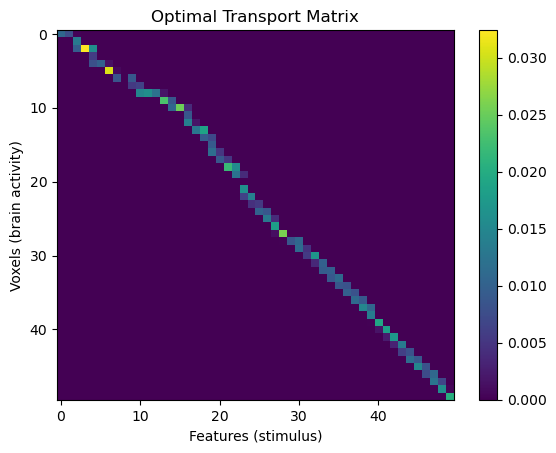

In [140]:
plt.imshow(transport_plans[3], aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Optimal Transport Matrix")
plt.xlabel("Features (stimulus)")
plt.ylabel("Voxels (brain activity)")
plt.show()